In [2]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Segmenting the Vibration  signal into small portions using a window

In [3]:
df = pd.read_csv('data/process_data.csv')

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=1000
stride=200

X=[]
Y=[]


for k in df['fault'].unique():
    
    df_temp_2 = df[df['fault']==k]
    
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])
    
X=np.array(X)
X=X.reshape((X.shape[0],win_len))



Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)
X.shape

2023-12-06 16:11:38.849176: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 16:11:38.875927: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 16:11:38.973051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 16:11:38.973100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 16:11:38.988019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

(6664, 1000)

## Splitting the data into Train and Test

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

## Visulaizing the data using t-sne before using Auto-Encoders

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6664 samples in 0.004s...
[t-SNE] Computed neighbors for 6664 samples in 0.875s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6664
[t-SNE] Computed conditional probabilities for sample 2000 / 6664
[t-SNE] Computed conditional probabilities for sample 3000 / 6664
[t-SNE] Computed conditional probabilities for sample 4000 / 6664
[t-SNE] Computed conditional probabilities for sample 5000 / 6664
[t-SNE] Computed conditional probabilities for sample 6000 / 6664
[t-SNE] Computed conditional probabilities for sample 6664 / 6664
[t-SNE] Mean sigma: 0.877359
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.801476
[t-SNE] KL divergence after 300 iterations: 3.801923


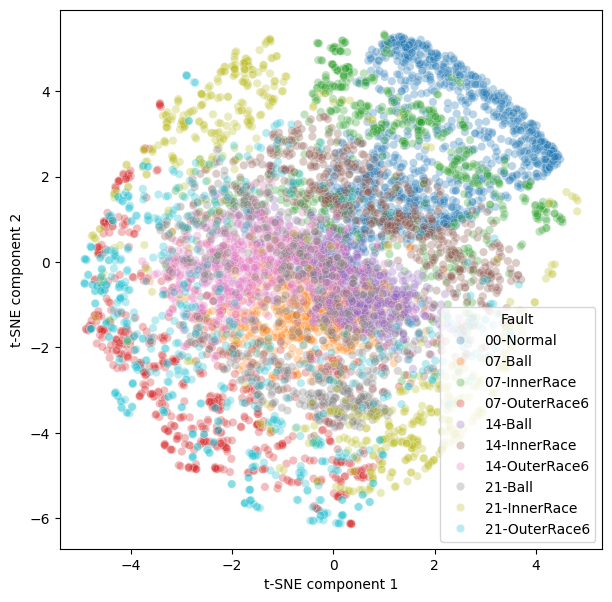

In [6]:
X_pre_aen = X

from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_aen)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

tSNEdf['Fault']=Y


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

## Create the model

In [7]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten


# from tensorflow.keras.models import load_model
# AE_model = load_model(r'Trained Model\AE_model_gear.h5')


no_classes=len(encoder.classes_)
# build a model
model = Sequential()
model.add(Dense(1024, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))
model.summary()

# compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1025024   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1715338 (6.54 MB)
Trainable params: 1715338 (6.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-06 16:11:58.241833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 16:11:58.242581: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Train the model

In [8]:
history = model.fit(X_train,
                    y_train,
                    epochs=50, # you can set this to a big number!
                    batch_size=500,
                    shuffle=True,
                    validation_data=(X_test,y_test),
                    verbose=1)

Epoch 1/50
10/10 [==============================] - 1s 48ms/step - loss: 2.0738 - accuracy: 0.1983 - val_loss: 1.8432 - val_accuracy: 0.4250
Epoch 2/50
10/10 [==============================] - 0s 35ms/step - loss: 1.4725 - accuracy: 0.5474 - val_loss: 1.1695 - val_accuracy: 0.6665
Epoch 3/50
10/10 [==============================] - 0s 35ms/step - loss: 0.7183 - accuracy: 0.8315 - val_loss: 0.6121 - val_accuracy: 0.8330
Epoch 4/50
10/10 [==============================] - 0s 35ms/step - loss: 0.2670 - accuracy: 0.9513 - val_loss: 0.3020 - val_accuracy: 0.9275
Epoch 5/50
10/10 [==============================] - 0s 34ms/step - loss: 0.0760 - accuracy: 0.9899 - val_loss: 0.2861 - val_accuracy: 0.9260
Epoch 6/50
10/10 [==============================] - 0s 34ms/step - loss: 0.0431 - accuracy: 0.9927 - val_loss: 0.3311 - val_accuracy: 0.9310
Epoch 7/50
10/10 [==============================] - 0s 34ms/step - loss: 0.0919 - accuracy: 0.9831 - val_loss: 0.2944 - val_accuracy: 0.9270
Epoch 8/50
10

# Plot the accuracy and loss function

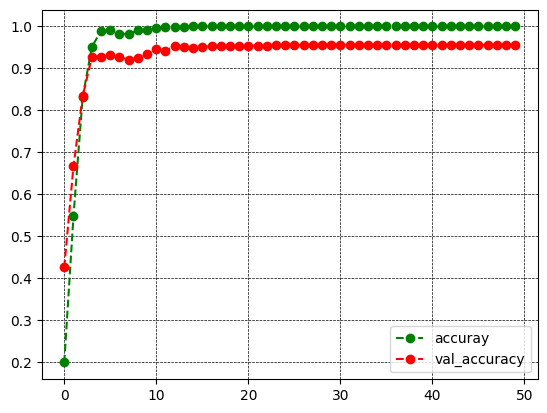

In [9]:
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['accuray','val_accuracy'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

## visualize predictions in a confusion matrix

63/63 [==============================] - 0s 2ms/step


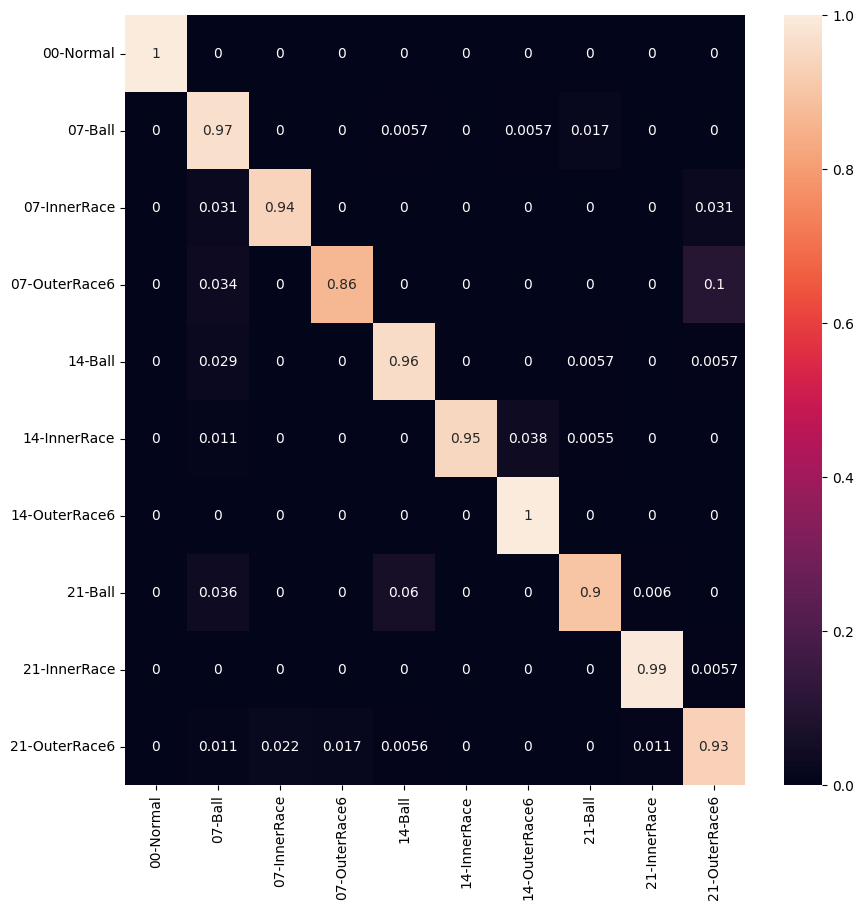

In [10]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

### visualize grouping, see if data is separable

In [11]:
dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
y_viz = dummy_ann.predict(X_train)
y_viz.shape

146/146 [==============================] - 0s 2ms/step


(4664, 128)

146/146 [==============================] - 0s 2ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4664 samples in 0.000s...
[t-SNE] Computed neighbors for 4664 samples in 0.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4664
[t-SNE] Computed conditional probabilities for sample 2000 / 4664
[t-SNE] Computed conditional probabilities for sample 3000 / 4664
[t-SNE] Computed conditional probabilities for sample 4000 / 4664
[t-SNE] Computed conditional probabilities for sample 4664 / 4664
[t-SNE] Mean sigma: 2.867981
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.283718
[t-SNE] KL divergence after 300 iterations: 1.808774


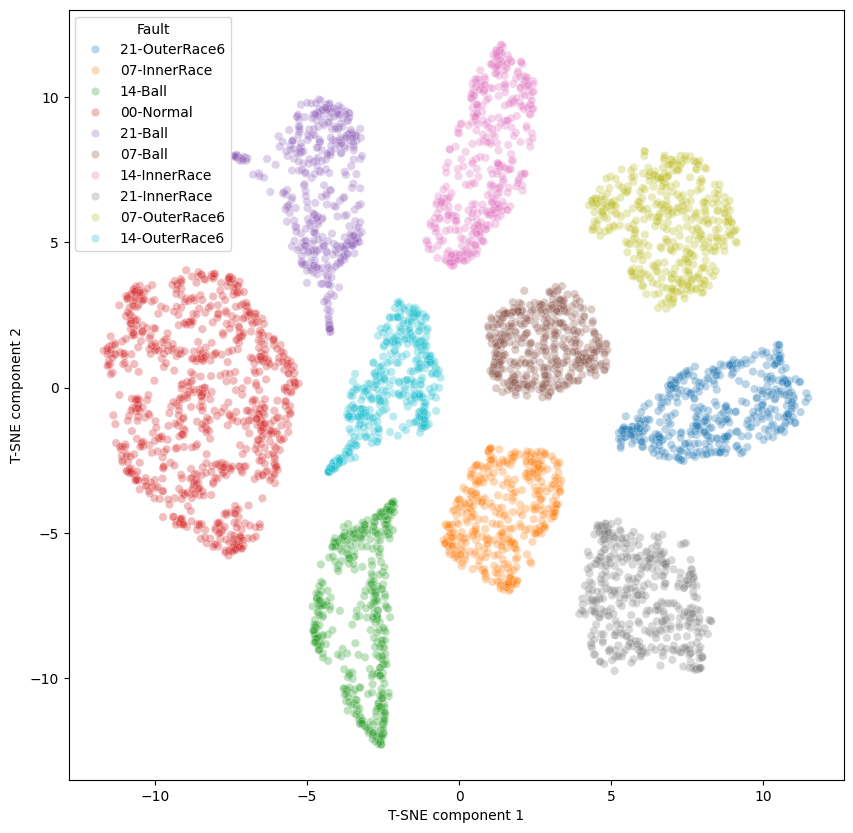

In [12]:
def T_SNE_plot(X_train,y_train,model,encoder):
    
    dummy_ann = Model(inputs=model.input,outputs=model.layers[-2].output)
    y_viz = dummy_ann.predict(X_train)
    
    from sklearn.manifold import TSNE

    X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

    tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

    tSNEdf['Fault']=inv_Transform_result(y_train)


    # Plot the PC-1 and PC-2
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
        data=tSNEdf,
        legend="full",
        alpha=0.3)
    plt.show()
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()
T_SNE_plot(X_train,y_train,model,encoder)


In [13]:
## summarize the model performance
print("perf", model.evaluate(X_test, y_test))
## total model parameters
model.summary()

63/63 [==============================] - 0s 2ms/step - loss: 0.2301 - accuracy: 0.9560
perf [0.2301337867975235, 0.9559999704360962]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1025024   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1715338 (6.54 MB)
Trainable params: 17153

In [14]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open('ann_dlsv' + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfvzinkqh/assets


INFO:tensorflow:Assets written to: /tmp/tmpfvzinkqh/assets
2023-12-06 16:12:23.162597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-06 16:12:23.162622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-06 16:12:23.162867: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfvzinkqh
2023-12-06 16:12:23.163588: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-06 16:12:23.163601: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfvzinkqh
2023-12-06 16:12:23.165180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-12-06 16:12:23.165982: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-06 16:12:23.214002: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

1724272

In [15]:
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

# Write TFLite model to a C source (or header) file
c_model_name = 'ann_dlsv'
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))